# Fourier Neural Operator for 3-Parameter Rugged Mueller Committor

In [708]:
import sys
sys.path.append('C:/Users/willi/Desktop/UMD REU/ruggedmueller/neuraloperator_main')

import neuraloperator_main.neuralop.__init__
import torch.nn.functional as F

import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
# from neuralop.models import TFNO

from neuraloperator_main.neuralop.models.tfno import TFNO


from neuralop import Trainer
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss


device = 'cpu'

# Data

In [709]:

# load data, drop headers
mesh = pd.read_csv("mueller_pts.csv", header = None)
committors = pd.read_csv("0_10gammacommittorsFEM.csv", header = None).drop(0)
betas = pd.read_csv("0_10gammapotentialFEM.csv", header = None).drop(0)
trig = pd.read_csv("mueller_tri.csv", header = None)
variableorder = pd.read_csv("varstorage.csv", header = None).drop(0)


In [710]:
#convert data type
dfinput = pd.DataFrame.astype(betas, 'float32')
# dfoutput = pd.DataFrame.astype(committors, 'float32')
dfoutput = committors


In [711]:
#convert to numpy array
datainput = pd.DataFrame.to_numpy(dfinput)

dataoutput = pd.DataFrame.to_numpy(dfoutput)

tri = pd.DataFrame.to_numpy(trig)

grid = pd.DataFrame.to_numpy(mesh)

variableorder = pd.DataFrame.to_numpy(variableorder)

In [712]:
order = np.arange(len(datainput))
np.random.shuffle(order)

datainput = datainput[order]
dataoutput= dataoutput[order]
    


In [713]:
print(order[800:])

[  9 794 580 673 793  64 483 874 559 514 399 464 219 150 713 541 368 871
 176 292 115 768 562 207 752 643 959 655 769 623 351 728 297  15 746  59
 865 997 430  61 658 648 288 363  56 629 952  86 403 867 796 912 864 703
 345 783 518   0 235 777 277 683 910  88 892 255 900 999 385 182 101 126
 776 186 408 767 711  81 622  72 227 642 501 220 429  36 944 200 377 582
 962 440 521 715 594 427  48  82 577 525 472 666 735 312 287 829  68 949
 476 162 899 410 742 901 444 349 540 509 305  21 330 497 690 354 773 445
 400 229 608 409  55 512 818 661 291  52 264 688 775 884 240 470 301 386
 779 679 814 890 734 647 390 603 536 332 214 583 309 247 926 700 558 128
 750 505 504 674 339  83 977 378 821 797 187  67 248 100 945 601 302 765
 190  42 766 148 610 450 682 141 948 625 822 857 933 431 631 575 506 828
 923 387]


In [714]:
# split into input/output, test + train

samples = len(datainput)

n_train = int(np.round(.8*samples))
n_test = samples - n_train

x_train = datainput[0:n_train,:]
x_test = datainput[n_train:samples,:]

y_train = dataoutput[0:n_train,:]
y_test = dataoutput[n_train:samples,:]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(len(x_train))
print(len(x_test))

800
200


In [715]:
# x_train = x_train[::400]
# y_train = y_train[::400]
# x_test = x_test[::4]
# y_test = y_test[::4]
# len(x_train)

In [716]:
#convert data into dictionary

trainn = []
testt = []


for i in range(len(x_train)):
    trainn.append({"x": torch.reshape(x_train[i], (87,53)), "y": torch.unsqueeze(torch.reshape(y_train[i],(87,53)), 0)})
    

for i in range(len(x_test)):
    testt.append({"x": torch.reshape(x_test[i], (87,53)), "y": torch.unsqueeze(torch.reshape(y_test[i], (87,53)), 0)})


In [717]:
# append grid of points

grid =  pd.DataFrame.astype(mesh, 'float32')
grid = pd.DataFrame.to_numpy(grid)

grid0 = [item[0] for item in grid]
grid1 = [item[1] for item in grid]


grid0 = torch.reshape(torch.Tensor(grid0), (87,53))
grid1 = torch.reshape(torch.Tensor(grid1), (87,53))




In [718]:

for i in range(len(trainn)):
    trainn[i]["x"] = torch.stack([trainn[i]["x"], grid0, grid1])
#     trainn[i]["y"] = trainn[i]["y"].unsqueeze(1)


    trainn[i]["x"] = trainn[i]["x"].squeeze()
#     trainn[i]["y"] = trainn[i]["y"].squeeze()

    
for i in range(len(testt)):
    testt[i]["x"] = torch.Tensor(torch.stack([testt[i]["x"], grid0, grid1]))
#     testt[i]["x"] = torch.permute(testt[i]["x"],  (0,2,1))

    
#     testt[i]["y"] = testt[i]["y"].unsqueeze(1)
#     testt[i]["y"] = torch.permute(testt[i]["y"], (0,2,1))


    testt[i]["x"] = testt[i]["x"].squeeze()
#     testt[i]["y"] = testt[i]["y"].squeeze()
    



In [719]:
batch_train = 16
batch_test = 1

# load data

    
train_loader = torch.utils.data.DataLoader(trainn, batch_size=batch_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testt, batch_size=batch_test, shuffle=False)

# Model



In [720]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', 
               rank=0.42, n_modes_height = 16)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 393665 parameters.


In [654]:
# Error metrics:
#
# mean absolute error MAE
# MAE = 1/(#FEM pts) sum_{all FEM pts} |q_{FNO}(x_j) - q_{FEM}(x_j)|
#
# weighted mean absolute error wMAE
#
# wMAE = sum_{all FEM pts} w(x_j)*|q_{FNO}(x_j) - q_{FEM}(x_j)|  
# where
# w(x_j) = exp(-beta*V(x_j))*q(x_j)*(1-q(x_j)) 
# w(x_j) = w(x_j)/sum of all w(x_k)

#Custom Losses

def wMAE(output, target, weights):
#     x = output[i].reshape(-1)
#     y = target[i].reshape(-1)
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    weights = weights * y * (1-y)
    Z = torch.sum(weights)
    error = torch.squeeze(torch.abs(x - y)*weights*(1/Z))
    error = torch.sum(error)
    
    
    return error 

def MAE(output, target):
    batches = output.size()[0]
    for i in range(batches): 
        x = output[i].reshape(-1)
        y = target[i].reshape(-1)
        error = torch.abs(x - y)*(1/len(x))
    return torch.sum(error)


def MAE2(target,output):
    # for numpy simple calculations
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.abs(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

In [645]:
yy = torch.Tensor([1,2,3])
yy*yy

tensor([1., 4., 9.])

In [646]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
l1loss = LpLoss(d=2, p=1)

train_loss = h1loss
eval_losses={'h1': h1loss}

In [634]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-5, 
                                weight_decay=1e-4)
optimizer2 = torch.optim.SGD(model.parameters(), 
                             lr = 8e-5, weight_decay = 
                             1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 8e-05
    lr: 8e-05
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x000002178A8724F0>

 * Test: {'h1': <neuralop.training.losses.H1Loss objec

## Training


In [688]:
trainer = Trainer(model, n_epochs=30,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


In [689]:
scheduler.load_state_dict(annealing)

In [690]:
trainer.train(train_loader, test_loader,
              None,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 800 samples
Testing on [200] samples         on resolutions ['test'].
Training on raw inputs of size x.shape=torch.Size([16, 3, 87, 53]), y.shape=torch.Size([16, 1, 87, 53])
.. patched inputs of size x.shape=torch.Size([16, 3, 87, 53]), y.shape=torch.Size([16, 1, 87, 53])
Raw outputs of size out.shape=torch.Size([16, 1, 87, 53])
.. Processed (unpatched) outputs of size out.shape=torch.Size([16, 1, 87, 53])
[0] time=30.51, avg_loss=0.8674, train_err=0.0325, test_h1=0.0273
[3] time=30.00, avg_loss=0.6309, train_err=0.0237, test_h1=0.0247
[6] time=30.73, avg_loss=0.6119, train_err=0.0229, test_h1=0.0238
[9] time=31.33, avg_loss=0.6019, train_err=0.0226, test_h1=0.0236


KeyboardInterrupt: 

In [721]:
#torch.save(model.state_dict(), '60epoch.txt')
model.load_state_dict(torch.load('6020epoch.txt'))

<All keys matched successfully>

In [722]:
annealing = scheduler.state_dict()

## Evaluate Model

In [723]:
totalwmae = 0
totalmae = 0
for data in test_samples:
    test_samples = test_loader.dataset

    data = test_samples[i]
    params = variableorder[order[i+800]]

    x = data['x']
    y = data['y']

    out = model(x.unsqueeze(0))
    
    out = out.detach().numpy()[0][0]

    out = np.reshape(out, -1)

    y = y.detach().numpy()
    y = np.reshape(y, -1)

    pot = x[0]
    pot = torch.reshape(pot, (-1,))
    npot = torch.Tensor.numpy(pot)

    totalwmae += wMAE(out, y, pot)
    totalmae += MAE2(out, y)

totalwmae = totalwmae / 200
totalmae = totalwmae / 200

print(totalwmae)
print(totalmae)

tensor(0.0055)
tensor(2.7296e-05)


In [724]:
i=1

params = variableorder[order[1]]

#1800
#150
#1000
#360

#1000 (mega)

#690

#402 (goood model)


#96

#50

#30

#50


In [747]:
np.arange(0, 1, .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [754]:
def graphsample(i):
#i is the test sample numer
    plt.rcParams.update({'font.size': 20})
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    test_samples = test_loader.dataset

    data = test_samples[i]
    params = variableorder[order[i+800]]

    x = data['x']
    y = data['y']

    out = model(x.unsqueeze(0))
    
    out = out.detach().numpy()[0][0]

    out = np.reshape(out, -1)

    y = y.detach().numpy()
    y = np.reshape(y, -1)

    pot = x[0]
    pot = torch.reshape(pot, (-1,))
    npot = torch.Tensor.numpy(pot)


    print("wMAE:" + str(wMAE(out, y, pot)))
    print("MAE:" + str(MAE2(out, y)))


    
    nx,ny= (100,100)
    nxy = nx*ny

    xmin = -4
    xmax = 2
    ymin = -2
    ymax = 4

    x1 = np.linspace(xmin,xmax,nx)
    y1 = np.linspace(ymin,ymax,ny)
    x_grid, y_grid = np.meshgrid(x1,y1)
    x_vec = np.reshape(x_grid, (nxy,1))
    y_vec = np.reshape(y_grid, (nxy,1))
    v = np.zeros(nxy)
    xy = np.concatenate((x_vec,y_vec),axis=1)
    # print('xy',xy)
    v = mueller(xy, params[1], params[2]) 
    vmin = np.amin(v)
    v_grid = np.reshape(v,(nx,ny))    
    fig1 = plt.figure(figsize=(12, 12))



    plt.tricontourf(grid[:,0], grid[:,1],tri, out , np.linspace(-.01, 1.01, 11))
    plt.colorbar(label="Committor", ticks = np.arange(0,1.1,.1), orientation="vertical", fraction=0.043, pad=0.05)
    plt.xlim([-3,1.5])
    plt.ylim([-1,3])
    plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')
    axes=plt.gca()
    axes.set_aspect(1)

    plt.title("FNO model," + "β = " + str(round(params[0], 2)) + "," + "γ = " + str(round(params[1], 2)) + "," + "k = " + str(round(params[2],2)))
    plt.savefig("FNO_model.pdf")

    # plt.title("FNO value for beta" + "=" + str(round(beta, 2)))

    #also print beta

    #plot level sets of potential (thin white curves) (maybe even make a function)

    #manuscript under 10 MB (reduce contoursm etc.)

    #subtract neural network vs "true" solution (use tricontour), save in pdf format 


    fig2 = plt.figure(figsize=(12, 12))

    plt.tricontourf(grid[:,0], grid[:,1],tri, y, np.linspace(0, 1.0, 11))
    plt.colorbar(label="Committor", orientation="vertical",  fraction=0.043, pad=0.05)
    plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')
    plt.xlim([-3,1.5])
    plt.ylim([-1,3])
    plt.title("Ground-Truth," + "β = " + str(round(params[0], 2)) + "," + "γ = " + str(round(params[1], 2)) + "," + "k = " + str(round(params[2],2)))

    axes=plt.gca()
    axes.set_aspect(1)

    plt.savefig("ground_truth.pdf")


    # plt.rcParams.update({'font.size': 10})
    # plt.title("True Value for beta" + "=" + str(round(beta, 4)))

    fig2 = plt.figure(figsize=(12, 12))

    plt.tricontourf(grid[:,0], grid[:,1],tri, np.abs(out - y), np.linspace(0, .1, 11))
    plt.colorbar(label="Error", orientation="vertical",  fraction=0.043, pad=0.05)
    plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,30), colors='white')
    plt.xlim([-3,1.5])
    plt.ylim([-1,3])
    plt.title("Absolute Error," + "β = " + str(round(params[0], 2)) + "," + "γ = " + str(round(params[1], 2)) + "," + "k = " + str(round(params[2],2)))

    axes=plt.gca()
    axes.set_aspect(1)

    plt.savefig("absolute_error.pdf")


#.135.836

wMAE:tensor(0.0130)
MAE:tensor(0.0060)


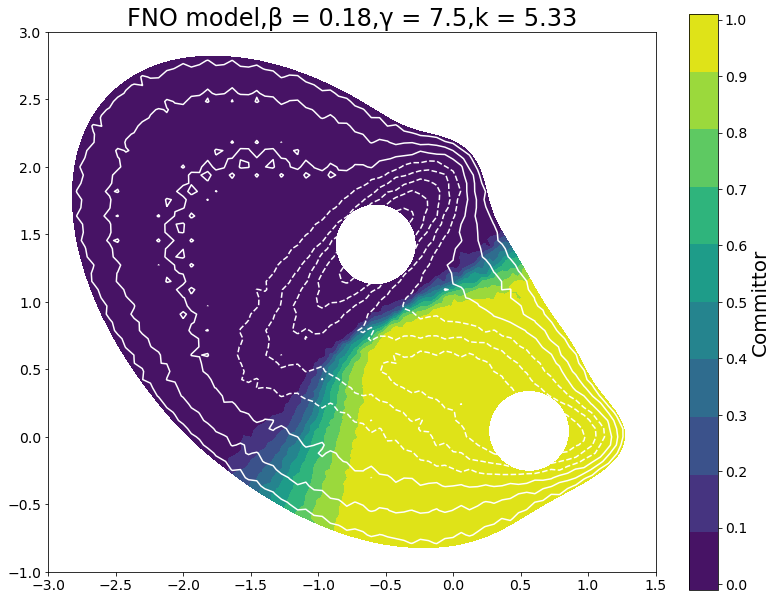

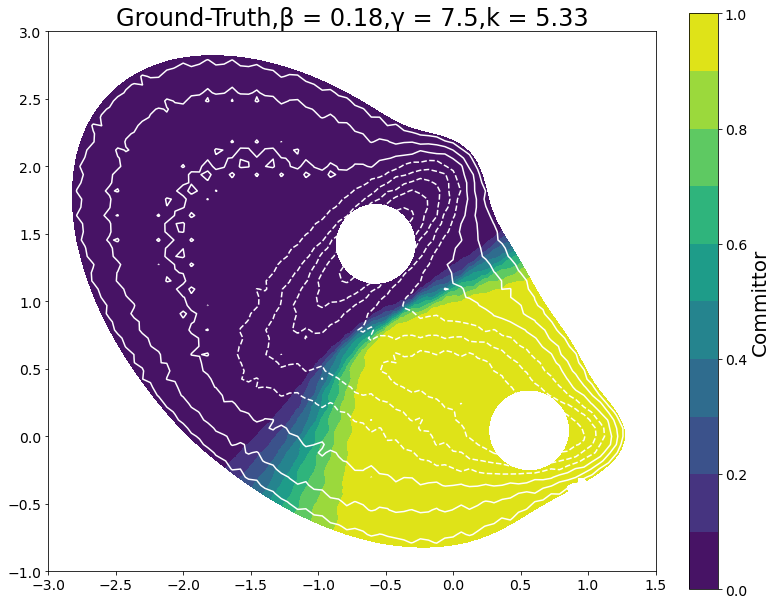

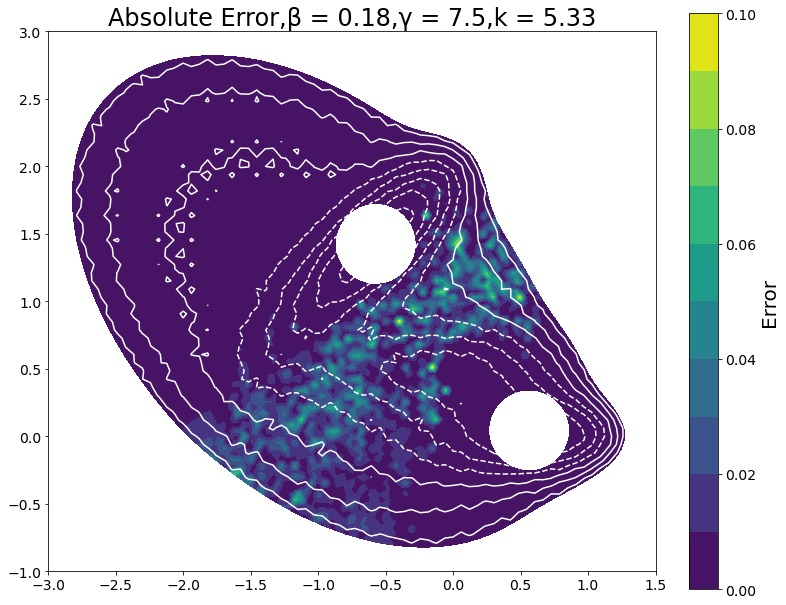

In [758]:
graphsample(7)

In [414]:
no = 2

In [415]:
test_samples = test_loader.dataset

data = test_samples[no]

x = data['x']
y = data['y']

out = model(x.unsqueeze(0))
    
out = out.detach().numpy()[0][0]

out = np.reshape(out, -1)

y = y.detach().numpy()
y = np.reshape(y, -1)

pot = x[0]
pot = torch.reshape(pot, (-1,))
npot = torch.Tensor.numpy(pot)


In [281]:
print(len(out))
print(len(npot))

4611
4611


In [272]:

wMAE(out, y, pot)

tensor(0.5750)

In [273]:

MAE2(out, y)

tensor(0.0072)

In [304]:
from numpy import sin, cos, tanh,exp
import math

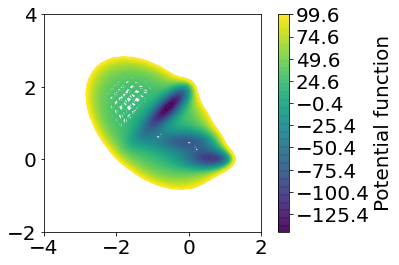

In [305]:
# parameters for Rugged Mueller's potential
xa= -0.572748881431767
ya= 1.426146532438478
xb= 0.563037564766839
yb= 0.044067357512953

ra = 0.3 # radius of set A
rb = 0.3 # radius of set B

beta = .06 # beta = 1/(k_B T), T = temperature, k_B = Boltzmann's constant

Vbdry = 100 # level set of the outer boundary {x : fpot(x) = Vbdry}

#300 

# if generate_mesh = True, mesh is generated and saves as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = False
# h0 is the desired scalind parameter for the mesh
h0 = 0.05


def mueller(x, gamma, k):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])
    # gamma = 9
    # k = 5
  
    fx1 = D[0]*np.exp(a[0]*((x[:,0]-X[0])**(2)) + b[0]*(x[:,0]-X[0])*(x[:,1]-Y[0]) + c[0]*((x[:,1]-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x[:,0]-X[1])**(2)) + b[1]*(x[:,0]-X[1])*(x[:,1]-Y[1]) + c[1]*((x[:,1]-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x[:,0]-X[2])**(2)) + b[2]*(x[:,0]-X[2])*(x[:,1]-Y[2]) + c[2]*((x[:,1]-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x[:,0]-X[3])**(2)) + b[3]*(x[:,0]-X[3])*(x[:,1]-Y[3]) + c[3]*((x[:,1]-Y[3])**(2)))
    extra = gamma*sin(2*k*math.pi*x[:,0])*sin(2*k*math.pi*x[:,1])
    
    U = fx1+fx2+fx3+fx4
    U = U+extra
    return U

# def rugged_muller(x):

# define the potential on a meshgrid
nx,ny= (100,100)
nxy = nx*ny

xmin = -4
xmax = 2
ymin = -2
ymax = 4

x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
# print('xy',xy)
v = mueller(xy, params[1], params[2]) 
vmin = np.amin(v)
v_grid = np.reshape(v,(nx,ny))    
# graphics
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,np.arange(vmin,Vbdry,1))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


4611
4611


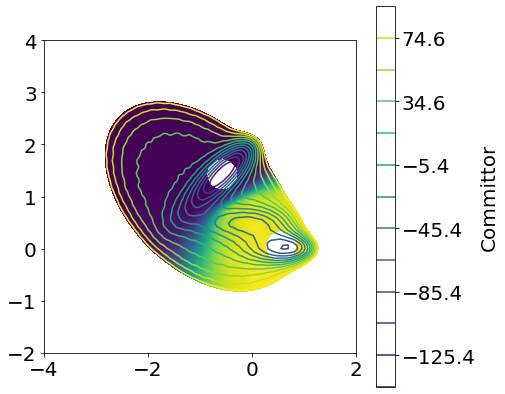

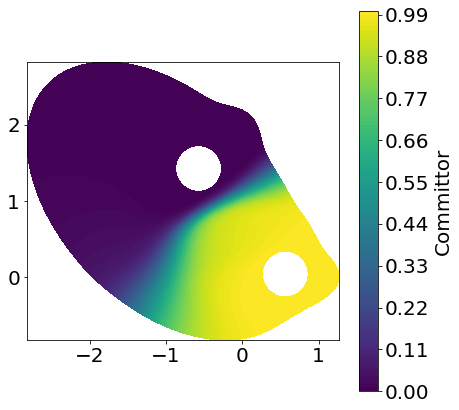

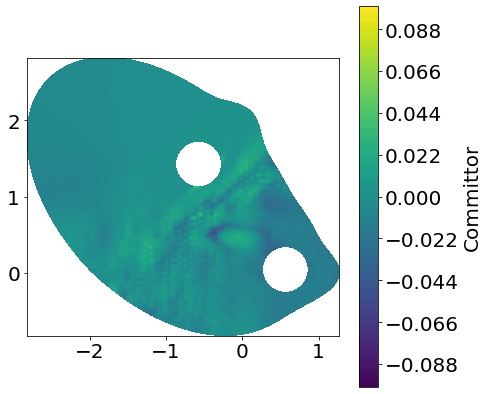

In [306]:
fig1 = plt.figure(figsize=(7, 7))

plt.tricontourf(grid[:,0], grid[:,1],tri, out , np.linspace(0, 1, 100))
plt.contour(x_grid,y_grid,v_grid, np.arange(vmin,Vbdry,20))
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
# plt.rcParams.update({'font.size': 20})
# plt.title("FNO value for beta" + "=" + str(round(beta, 2)))



#also print beta

#plot level sets of potential (thin white curves) (maybe even make a function)

#manuscript under 10 MB (reduce contoursm etc.)

#subtract neural network vs "true" solution (use tricontour), save in pdf format 


fig2 = plt.figure(figsize=(7, 7))

plt.tricontourf(grid[:,0], grid[:,1],tri, y, np.linspace(0, 1, 101))
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
# plt.rcParams.update({'font.size': 20})
# plt.title("True Value for beta" + "=" + str(round(beta, 4)))

fig2 = plt.figure(figsize=(7, 7))

plt.tricontourf(grid[:,0], grid[:,1],tri, out - y, np.linspace(-.1, .1, 101))
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
